# SQLAlchemy Tutorial

In [1]:
%%capture
!pip install sqlalchemy

In [2]:
import sqlalchemy as db
import pandas as pd
db.__version__

'2.0.44'

## Pasos iniciales

### Conexión a la base de datos

In [3]:
from sqlalchemy import create_engine
engine = create_engine("sqlite:///european_database.sqlite")

### Objeto tabla

In [5]:
conn = engine.connect()
metadata = db.MetaData()
division = db.Table('divisions', metadata, autoload_with=engine)

In [6]:
print(division.columns.keys())

['division', 'name', 'country']


In [7]:
print(repr(metadata.tables['divisions']))

Table('divisions', MetaData(), Column('division', TEXT(), table=<divisions>), Column('name', TEXT(), table=<divisions>), Column('country', TEXT(), table=<divisions>), schema=None)


### Visualizando resultados

In [8]:
query = division.select()
exe = conn.execute(query)
result = exe.fetchmany(5)
print(result)

[('B1', 'Division 1A', 'Belgium'), ('D1', 'Bundesliga', 'Deutschland'), ('D2', '2. Bundesliga', 'Deutschland'), ('E0', 'Premier League', 'England'), ('E1', 'EFL Championship', 'England')]


### SQL query

In [9]:
print(query)

SELECT divisions.division, divisions.name, divisions.country 
FROM divisions


## Creación de tablas

In [10]:
engine = db.create_engine('sqlite:///datacamp.sqlite') 
conn = engine.connect()
metadata = db.MetaData()

Student = db.Table('Student', metadata,
              db.Column('Id', db.Integer(),primary_key=True),
              db.Column('Name', db.String(255), nullable=False),
              db.Column('Major', db.String(255), default="Math"),
              db.Column('Pass', db.Boolean(), default=True)
              )

metadata.create_all(engine) 

### Inserción de información

In [15]:
query = db.insert(Student).values(Id=1, Name='Matthew', Major="English", Pass=True) 
Result = conn.execute(query)
# Error por registro existente.

IntegrityError: (sqlite3.IntegrityError) UNIQUE constraint failed: Student.Id
[SQL: INSERT INTO "Student" ("Id", "Name", "Major", "Pass") VALUES (?, ?, ?, ?)]
[parameters: (1, 'Matthew', 'English', 1)]
(Background on this error at: https://sqlalche.me/e/20/gkpj)

In [13]:
result = conn.execute(db.select(Student))
rows = result.mappings().all()

print(rows) # visualización como diccionario


[{'Id': 1, 'Name': 'Matthew', 'Major': 'English', 'Pass': True}, {'Id': 2, 'Name': 'Nisha', 'Major': 'Science', 'Pass': False}, {'Id': 3, 'Name': 'Natasha', 'Major': 'Math', 'Pass': True}, {'Id': 4, 'Name': 'Ben', 'Major': 'English', 'Pass': False}]


In [14]:
output = conn.execute(
    db.select(Student)
).fetchall()

print(output)


[(1, 'Matthew', 'English', True), (2, 'Nisha', 'Science', False), (3, 'Natasha', 'Math', True), (4, 'Ben', 'English', False)]


### Inserción varios registros

In [12]:
query = db.insert(Student) 

values_list = [
    {'Id': 2, 'Name': 'Nisha',   'Major': 'Science', 'Pass': False},
    {'Id': 3, 'Name': 'Natasha', 'Major': 'Math',    'Pass': True},
    {'Id': 4, 'Name': 'Ben',     'Major': 'English', 'Pass': False}
]

conn.execute(query, values_list)
conn.commit()

In [17]:
output = conn.execute(db.select(Student)).fetchall()
print(output)

[(1, 'Matthew', 'English', True), (2, 'Nisha', 'Science', False), (3, 'Natasha', 'Math', True), (4, 'Ben', 'English', False)]


### Sentencia SQL Sencilla

In [19]:
from sqlalchemy import text

output = conn.execute(text("SELECT * FROM Student"))
print(output.fetchall())

[(1, 'Matthew', 'English', 1), (2, 'Nisha', 'Science', 0), (3, 'Natasha', 'Math', 1), (4, 'Ben', 'English', 0)]


In [20]:
output = conn.execute(db.select(Student))
print(output.fetchall())


[(1, 'Matthew', 'English', True), (2, 'Nisha', 'Science', False), (3, 'Natasha', 'Math', True), (4, 'Ben', 'English', False)]


In [21]:
output = conn.execute(text("SELECT Name, Major FROM Student WHERE Pass = True"))
print(output.fetchall())

[('Matthew', 'English'), ('Natasha', 'Math')]


## Utilizando la API de SQLAlchemy

### WHERE

In [22]:
query = Student.select().where(Student.columns.Major == 'English')
output = conn.execute(query)
print(output.fetchall())

[(1, 'Matthew', 'English', True), (4, 'Ben', 'English', False)]


### AND

In [23]:
query = Student.select().where(db.and_(Student.columns.Major == 'English', Student.columns.Pass != True))
output = conn.execute(query)
print(output.fetchall())

[(4, 'Ben', 'English', False)]


### ORDER BY

In [24]:
query = Student.select().order_by(db.desc(Student.columns.Name))
output = conn.execute(query)
print(output.fetchall())

[(2, 'Nisha', 'Science', False), (3, 'Natasha', 'Math', True), (1, 'Matthew', 'English', True), (4, 'Ben', 'English', False)]


### IN

In [25]:
query = Student.select().where(Student.columns.Major.in_(['English','Math']))
output = conn.execute(query)
print(output.fetchall())

[(1, 'Matthew', 'English', True), (3, 'Natasha', 'Math', True), (4, 'Ben', 'English', False)]


### LIMIT

In [26]:
query = Student.select().limit(3)
output = conn.execute(query)
print(output.fetchall())

[(1, 'Matthew', 'English', True), (2, 'Nisha', 'Science', False), (3, 'Natasha', 'Math', True)]


#### SUM

In [28]:
query = db.select(db.func.sum(Student.c.Id))
output = conn.execute(query)

print(output.fetchall())


[(10,)]


In [29]:
query = db.select(
    db.func.sum(Student.c.Id).label("total_id")
)

result = conn.execute(query).scalar()
print(result)


10


### GROUP BY

In [31]:

query = (
    db.select(
        db.func.sum(Student.c.Id).label("total_id"),
        Student.c.Major
    )
    .group_by(Student.c.Major)
)

result = conn.execute(query).all()
print(result)


[(5, 'English'), (3, 'Math'), (2, 'Science')]


### DISTINCT

In [33]:

query = db.select(Student.c.Major.distinct())
output = conn.execute(query)

print(output.fetchall())


[('English',), ('Science',), ('Math',)]


## Salida a Pandas DataFrame

In [34]:
query = Student.select().where(Student.columns.Major.in_(['English','Math']))
output = conn.execute(query)
results = output.fetchall()


In [36]:
result = conn.execute(query)
rows = result.mappings().all()

data = pd.DataFrame(rows)
data


,Id,Major,Name,Pass
0,1,English,Matthew,True
1,3,Math,Natasha,True
2,4,English,Ben,False


## Data Analytics con SQLAlchemy

### Preparando dos tablas


In [38]:
engine = create_engine("sqlite:///european_database.sqlite")
conn = engine.connect()
metadata = db.MetaData()
division = db.Table('divisions', metadata, autoload_with=engine)
match = db.Table('matchs', metadata, autoload_with=engine)

### Query

In [40]:
query = (
    db.select(division, match)
    .select_from(
        division.join(
            match,
            division.c.division == match.c.Div
        )
    )
    .where(
        db.and_(
            division.c.division == "E1",
            match.c.season == 2009
        )
    )
    .order_by(match.c.HomeTeam)
)

output = conn.execute(query)
results = output.fetchall()


### Transformar a DataFrame

In [42]:
result = conn.execute(query)
rows = result.mappings().all()

df = pd.DataFrame(rows)
df


,AwayTeam,Date,Div,FTAG,FTHG,FTR,HomeTeam,country,division,name,season
0,Coventry,2008-08-16,E1,2.0,1.0,A,Barnsley,England,E1,EFL Championship,2009
1,Derby,2008-08-30,E1,0.0,2.0,H,Barnsley,England,E1,EFL Championship,2009
2,Cardiff,2008-09-16,E1,1.0,0.0,A,Barnsley,England,E1,EFL Championship,2009
3,Norwich,2008-09-27,E1,0.0,0.0,D,Barnsley,England,E1,EFL Championship,2009
4,Doncaster,2008-10-04,E1,1.0,4.0,H,Barnsley,England,E1,EFL Championship,2009
...,...,...,...,...,...,...,...,...,...,...,...
547,Ipswich,2009-03-10,E1,0.0,0.0,D,Wolves,England,E1,EFL Championship,2009
548,Charlton,2009-03-14,E1,1.0,2.0,H,Wolves,England,E1,EFL Championship,2009
549,Southampton,2009-04-10,E1,0.0,3.0,H,Wolves,England,E1,EFL Championship,2009
550,QPR,2009-04-18,E1,0.0,1.0,H,Wolves,England,E1,EFL Championship,2009


### Visualización

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")


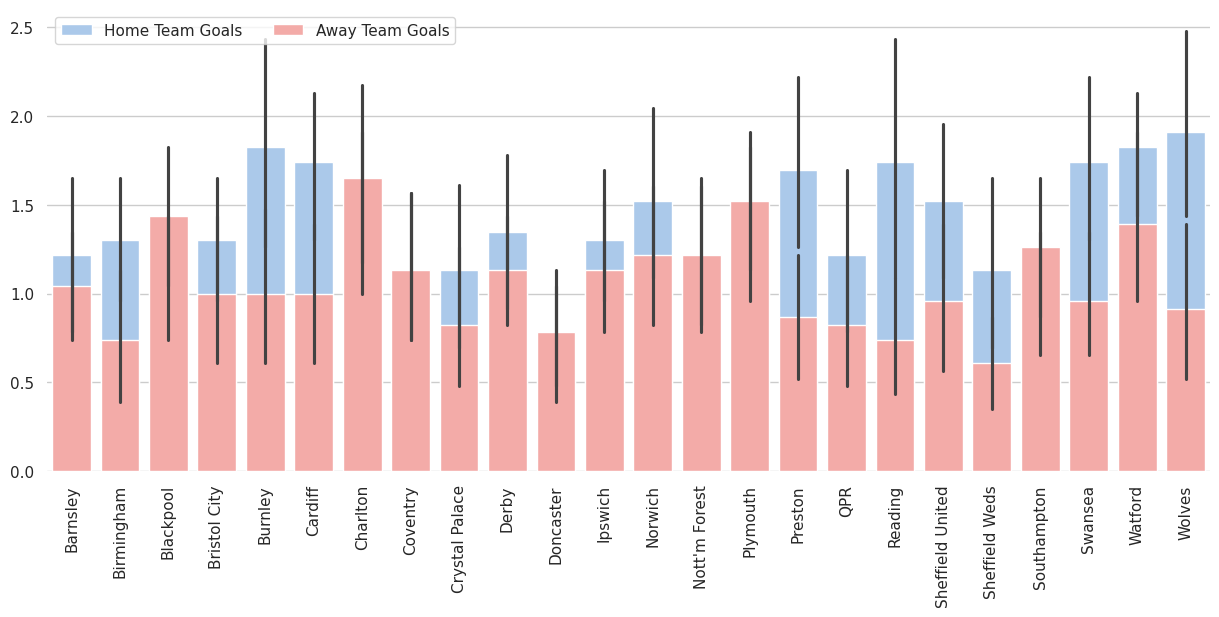

In [44]:
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation=90)
sns.set_color_codes("pastel")
sns.barplot(x="HomeTeam", y="FTHG", data=data,
            label="Home Team Goals", color="b")

sns.barplot(x="HomeTeam", y="FTAG", data=data,
            label="Away Team Goals", color="r")
ax.legend(ncol=2, loc="upper left", frameon=True)
ax.set(ylabel="", xlabel="")
sns.despine(left=True, bottom=True)

## SQL a CSV

In [48]:
from sqlalchemy import text

query = text("SELECT * FROM matchs WHERE HomeTeam = :team")
output = conn.execute(query, {"team": "Norwich"})
results = output.fetchall()


In [51]:
query = text("SELECT * FROM matchs WHERE HomeTeam LIKE :team")

result = conn.execute(query, {"team": "Norwich%"})


## CSV a Tabla SQL

In [53]:
engine = create_engine("sqlite:///datacamp.sqlite")

In [54]:
df = pd.read_csv('Stock Exchange Data.csv')
df.to_sql(con=engine, name="Stock_price", if_exists='replace',index=False)

2222

In [56]:
conn = engine.connect()
metadata = db.MetaData()
stock = db.Table('Stock_price', metadata, autoload_with=engine)

In [57]:
print(stock.columns.keys())

['Index', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'CloseUSD']


In [58]:
query = stock.select()
exe = conn.execute(query)
result = exe.fetchmany(5)
for r in result:
    print(r)

('HSI', '1986-12-31', 2568.300049, 2568.300049, 2568.300049, 2568.300049, 2568.300049, 0, 333.87900637)
('HSI', '1987-01-02', 2540.100098, 2540.100098, 2540.100098, 2540.100098, 2540.100098, 0, 330.21301274)
('HSI', '1987-01-05', 2552.399902, 2552.399902, 2552.399902, 2552.399902, 2552.399902, 0, 331.81198726)
('HSI', '1987-01-06', 2583.899902, 2583.899902, 2583.899902, 2583.899902, 2583.899902, 0, 335.90698726)
('HSI', '1987-01-07', 2607.100098, 2607.100098, 2607.100098, 2607.100098, 2607.100098, 0, 338.92301274)


## Gestión tablas SQL

### Actualizar valores de las tablas SQL

In [59]:
Student = db.Table('Student', metadata, autoload_with=engine)
query = Student.update().values(Pass = True).where(Student.columns.Name == "Nisha")
results = conn.execute(query)

In [61]:
result = conn.execute(Student.select())
rows = result.mappings().all()

data = pd.DataFrame(rows)
data


,Id,Major,Name,Pass
0,1,English,Matthew,True
1,2,Science,Nisha,True
2,3,Math,Natasha,True
3,4,English,Ben,False


### Borrar valores

In [62]:
Student = db.Table('Student', metadata, autoload_with=engine)
query = Student.delete().where(Student.columns.Name == "Ben")
results = conn.execute(query)

In [64]:
result = conn.execute(Student.select())
data = pd.DataFrame(result.mappings().all())
data


,Id,Major,Name,Pass
0,1,English,Matthew,True
1,2,Science,Nisha,True
2,3,Math,Natasha,True


### Borrar tablas

#### Cerrar todas las ejecuciones

In [65]:
results.close()
exe.close()

#### Drop de las tablas

In [67]:
conn.close()
Student.drop(engine)


In [68]:
metadata.drop_all(engine) #drop all tables